# Top ZipCodes in Harris County for Real Estate Investment

# Summary

A real estate investment company (the client) is interested in investing in real estate in Harris County, Texas, USA. The client asked us to recommend the top five zip codes they can consider for investment. To enable us make this recommendation, we sourced a public dataset from Zillow that contains high volumes of historical house prices in the USA. We utilized Time Series analysis (precisely SARIMA) to build a forecasting model to predict 3 years's worth of future house prices. With the predicted house prices, we calculated the expected return on investment (ROI) and recommended 5 zipcodes with the highest ROI.

Studying the dataset, we observed that the data had regular intervals (one month) and exhibited temporal dependencies or patterns hence its ability to capture seasonal trends and analyze (& predict) long term market trends, hence suitability for time series analysis. Presence of seasonality further informed our model choice: SARIMA (Seasonal Auto-Regressive Integrated Moving Average).

For data preparation, we defined the melt_function to format our data into normal time series. We located the Harris County dataset and performed preprocessing (checking for nulls, dtypes). We also checked the number of counties and the overall distribution/normality of the dataset. We performed the Dickey-Fuller test to establish whether the dataset is stationary, given that SARIMA assumes stationarity in the data. Our dataset was not stationary, hence we handled it via differencing (per Auto-ARIMA's optimized parameter recommendation).

We validated our SARIMA model workflow starting with a model for 1 zipcode. Given the ability to predict the general trend with an RMSE of 22,273.39, we were confident to use this model. Next, we implemented this workflow for all zipcodes in Harris county and forecasted the housing prices for the future period (36 months). We recommended the below 5 zipcodes that had the highest expected ROIs in the forecasted period.

Zip Code ROI Predictions:
- Zip Code 77092: 33.09%
- Zip Code 77003: 30.54%
- Zip Code 77062: 23.13%
- Zip Code 77586: 22.86%
- Zip Code 77345: 21.81%

# Business Understanding

A real estate investment firm wants to invest in Harris County, Texas for the first time. The firm has asked us to recommend the top five zip codes that they can invest in. The client is interested in properties with an average cost of $ 200,000 to $ 300,000 as at April 2018. 

Our task is to identify the best 5 Zip Codes which will have the highest ROI for the forseeible future i.e., approximately 3 years from purchase purchase. We will use Time Series modeling to make the top zip code predictions.

# Data Understanding

To perform this Time series analysis, I am using Zillow’s historical median house prices' dataset for the US.

The data contains descriptive variables indicating the region name (zip code), the region ID, city, county and state. It also contains an ordinal variable SizeRank, which after some data exploration, I assume ranks the zip codes by urbanization. More urbanized zip codes have a higher rank.The data contains 272 columns and 14,723 rows and contains data between April, 1996 to April, 2018. From column 9 upto 272, we have the zipcode house prices per month stored in the wide form. Using the melt_data(df) function below, we will convert the wide form to long-form that provides a time series dataset for our analysis.

## 1.0 Defining the melt_data() function

In [1]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# 1.1 Importing the required libraries

In [2]:
#Importing required Packages
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline

## 2.0 Load the data

In [3]:
#Loading dataset
df = pd.read_csv('zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


## 2.1 Exploring the Harris County dataset

Our client wants to invest in Harris County, Houston Texas, hence let us filter this dataframe to only include records within the specified region.

In [4]:
df_TX = df[df['State'] == 'TX']
Harris =  df_TX[df_TX['CountyName']=='Harris']
Harris

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
38,91922,77429,Cypress,TX,Houston,Harris,39,149600.0,148800.0,148100.0,...,237500,238000,238500,239200,240200,241300,241700,242200,243200,243800
44,91685,77036,Houston,TX,Houston,Harris,45,120400.0,118700.0,117300.0,...,174900,174600,175000,176000,177200,177700,177700,179800,185100,189800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8138,92028,77562,Highlands,TX,Houston,Harris,8139,67500.0,67500.0,67400.0,...,137300,137100,137800,140200,142800,144400,145000,145600,147200,148400
8230,91681,77032,Houston,TX,Houston,Harris,8231,57100.0,57100.0,57000.0,...,104800,105600,106500,108200,111200,113600,115600,117400,118800,119200
8357,91743,77094,Houston,TX,Houston,Harris,8358,356300.0,357700.0,358800.0,...,375100,374400,374100,374700,375300,375000,373400,372800,373600,373900
9487,92018,77547,Galena Park,TX,Houston,Harris,9488,44400.0,44400.0,44500.0,...,85100,81600,79400,79300,79400,79800,80300,80500,81700,83300


We can see from the above dataframe that the County area is divided into smaller cities within it. And some City regions like 'Katy', 'Houston', 'Cypress' seem to be further divided into different zipcode regions.

## Cities within Harris county in Houston

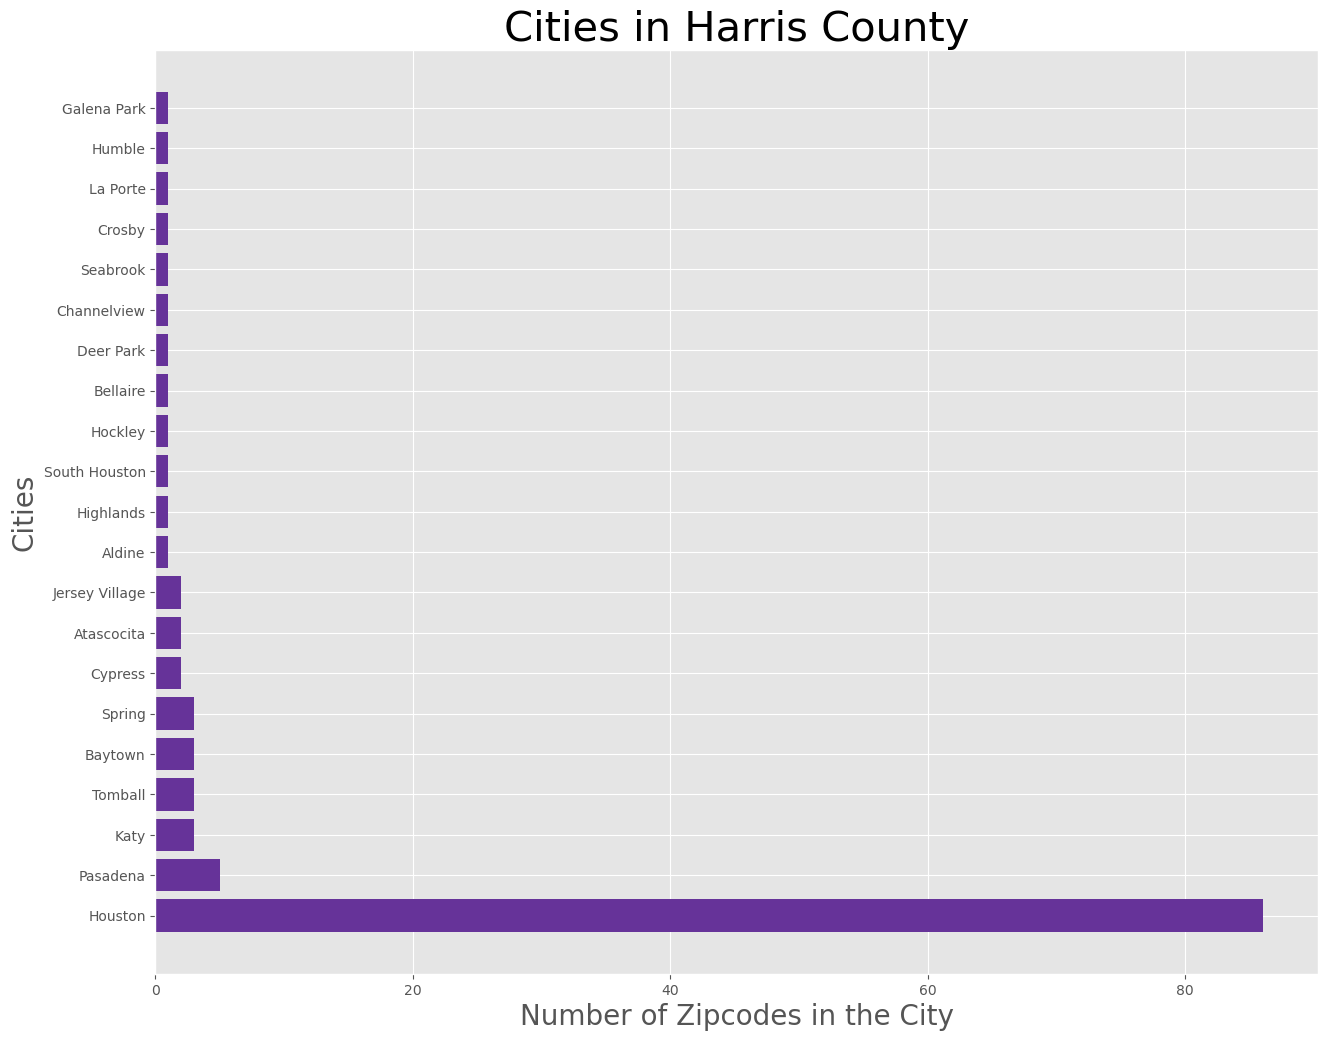

In [5]:
#Visualizing the value counts of zipcodes in each city in the Harris county

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in Harris['City'].value_counts()]

x = [a for a in Harris['City'].value_counts().keys()]

ax.barh(x,y,color='rebeccapurple')
ax.set_title('Cities in Harris County',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of Zipcodes in the City',fontsize=20);

The city of Houston is divided into the highest number of zipcodes.

Now that we have some understanding of our how the Harris county is divided, we can now narrow our focus based on our client's requirement.

In [6]:
#budget preference is a dataframe of Harris County with zipcodes having an average price under $350000 as of April, 2018.
Harris_budget = Harris[(Harris['2018-04'] > 200000) & (Harris['2018-04'] <= 300000)]

In [7]:
#List of Zip Codes in the Harris/Houston metro region within client's budget.
Harris_budget_zips = [a for a in Harris_budget['RegionName']]

View the number zipcodes we're left with:

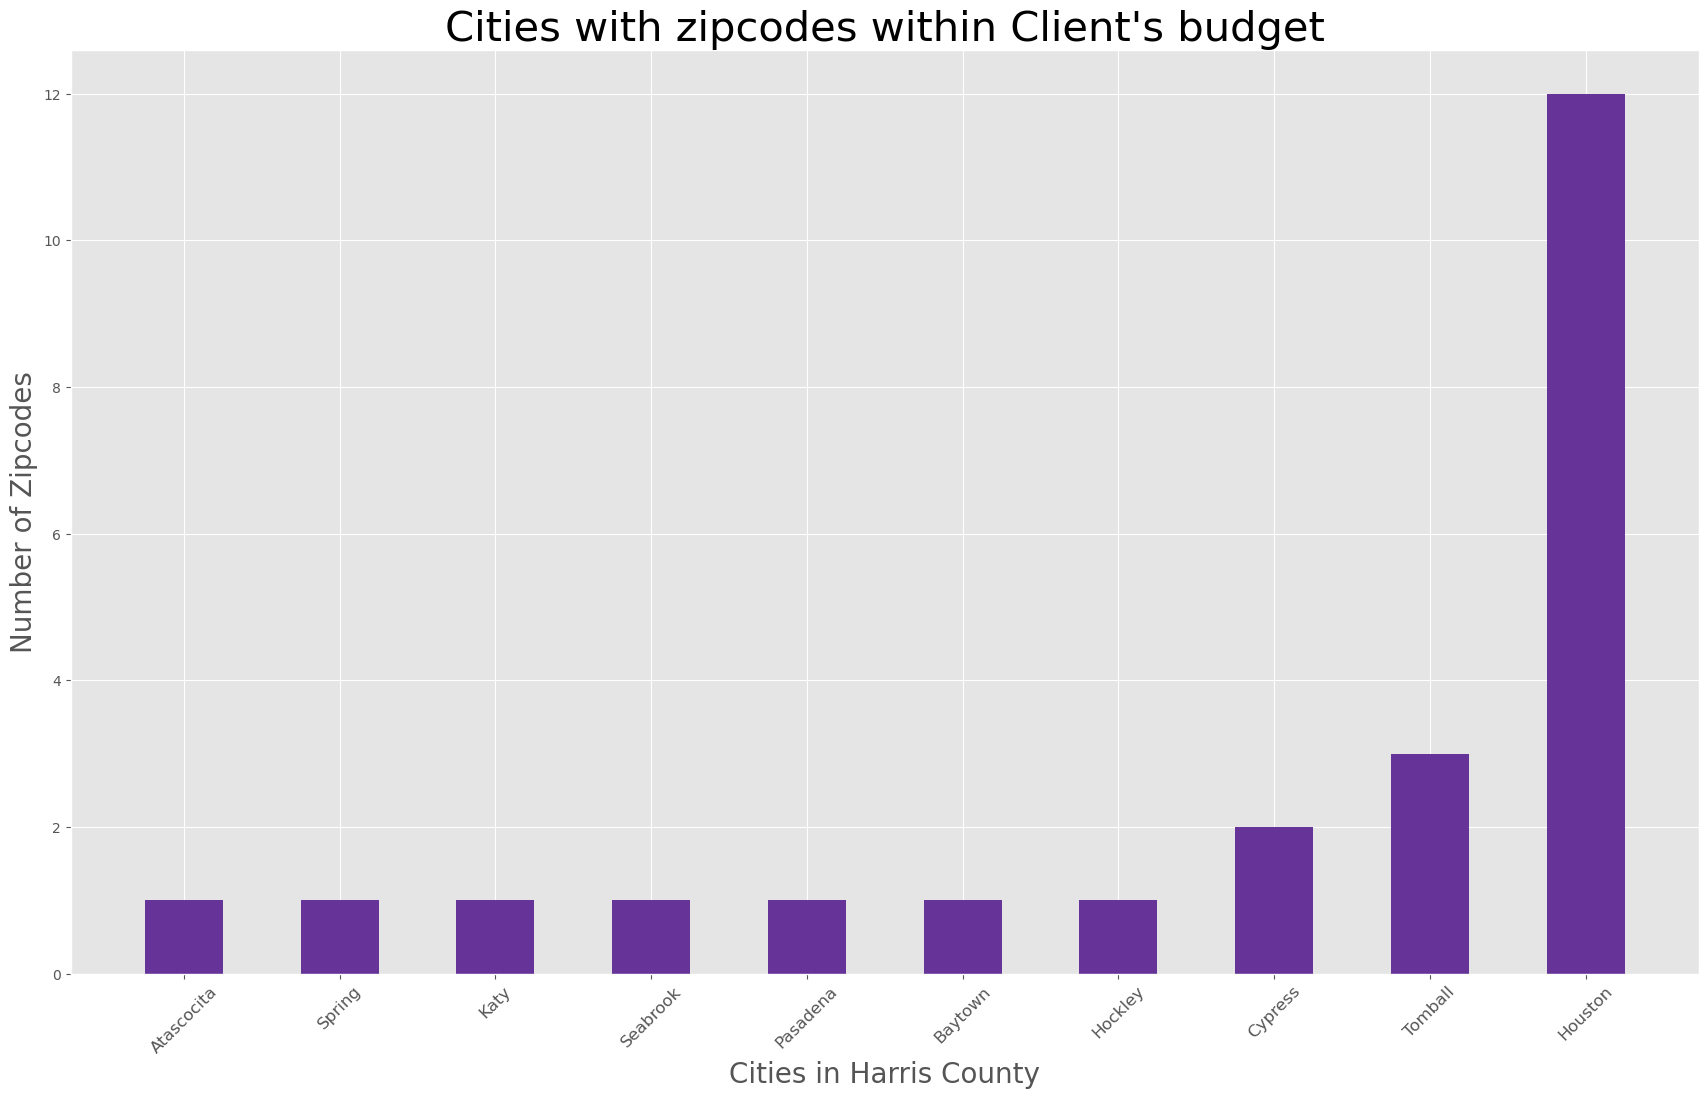

In [8]:
#Pulling necessary data from the dataframe for the bar chart

#Getting City Names
city_names = []

for zipcode in Harris_budget_zips:
    city_names.append(Harris_budget[Harris_budget['RegionName']==zipcode].iloc[0]['City'])

#Retrieving number of zipcodes for each city and feeding it to count_dict
count_dict = {}
for a in Counter(city_names).keys():
    count_dict[a] = Counter(city_names)[a]

#sorting dictionary into ascending order
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1]))

#Building the bar chart
fig,ax = plt.subplots(figsize=(21,12))

x_labels = [a for a in count_dict.keys()]
x = list(range(1,len(x_labels)+1))
y = [a for a in count_dict.values()]

ax.bar(x,y,color='rebeccapurple',width=0.5)

ax.set_xticks(x)
ax.set_xticklabels(x_labels,fontsize='12', rotation=45)
ax.set_title("Cities with zipcodes within Client's budget",fontsize='30')
ax.set_ylabel("Number of Zipcodes",fontsize='20')
ax.set_xlabel("Cities in Harris County",fontsize='20')
fig.savefig('Cities_Zipcodes_Budget.png');

## 2.2 Check for null values and dtypes

In [9]:
# Check for null values in the DataFrame
null_counts = Harris_budget.isna().sum()

# Filter columns with null values
columns_with_null = null_counts[null_counts > 0]

# Display columns with null values and their null value counts
print("Columns with Null Values:")
print(columns_with_null)

Columns with Null Values:
Series([], dtype: int64)


Observation: No null values

In [10]:
# Check for column data types, especially the price columns
Harris_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 38 to 8125
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 51.2+ KB


It seems all price columns are either floats or intergers, hence will support numerical operations

## 2.3 Visualizing the Price history of filtered Zip Codes since 1996

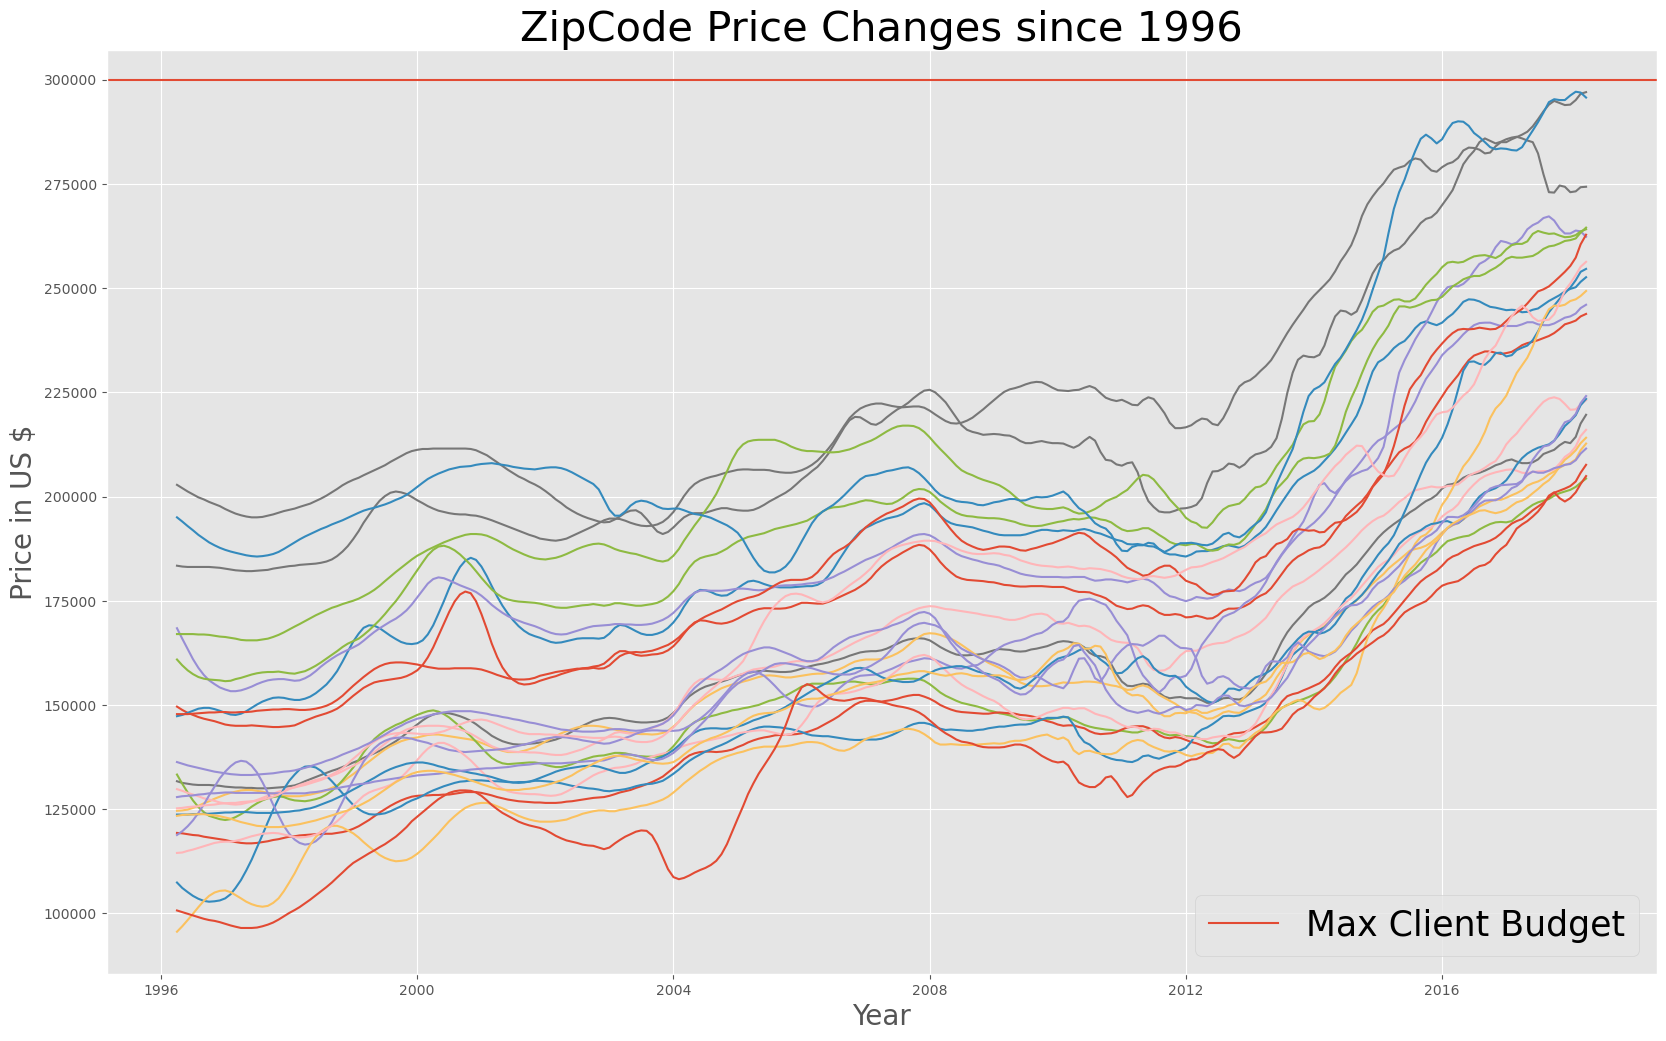

In [11]:
warnings.filterwarnings("ignore", category=UserWarning, message="The argument 'infer_datetime_format' is deprecated")

zip_dict = {}

for zipcode in Harris_budget_zips:
    zip_dict[zipcode] = melt_data(Harris_budget[Harris_budget['RegionName']==zipcode])

fig,ax = plt.subplots(figsize=(20,12))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode],)

ax.axhline(y=300000,label = 'Max Client Budget')   

ax.set_title('ZipCode Price Changes since 1996',fontsize=30)
ax.set_ylabel('Price in US $',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.legend(prop={'size': 25})
fig.savefig('ZipCode_Prices.png');

Prices in Harris county have been stable; growing incrementally between 1996 and 2004 with a limited dip observed in 2001. This price stability is observed during the 2008 recession where there is another small drop in overall prices. Since 2012 there has been a steady and significant rise on house prices.

## 2.4.1 Measuring return on investment (ROI)

ROI is popular measure that utilizes net gains (revenue - expenses) divided by cost of investment to obtain the return. We do not have expenses in the dataset. Though we will calculate ROI based on the revenues (prices) to provide an overall indication on the returns.

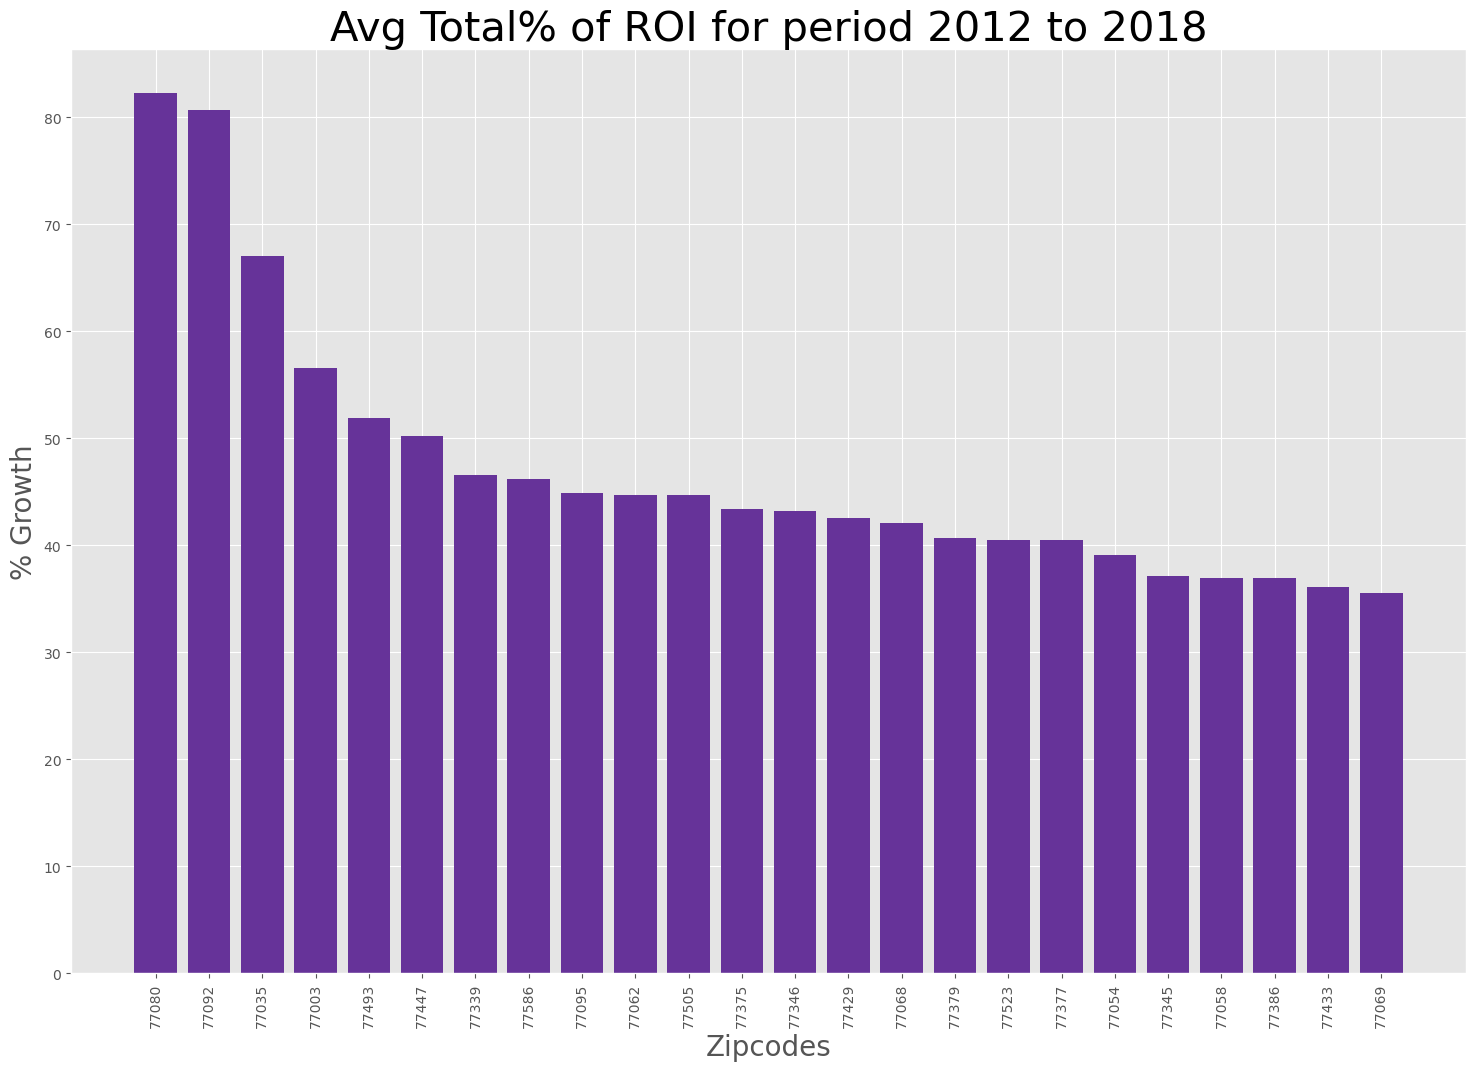

In [12]:
warnings.filterwarnings('ignore')
# Calculate ROI and handle NaN values
harris_ROI = Harris_budget.copy()
harris_ROI['ROI_since11'] = ((harris_ROI['2018-04'] - harris_ROI['2012-01']) / harris_ROI['2012-01']).fillna(0)

# Sort the DataFrame by 'ROI_since11' in descending order
harris_ROI = harris_ROI.sort_values('ROI_since11', ascending=False)

# Create the bar plot
fig, ax = plt.subplots(figsize=(18, 12))

x_labels = [str(a) for a in harris_ROI['RegionName']]
y = harris_ROI['ROI_since11']*100

ax.bar(x_labels, y, color='rebeccapurple')

ax.set_ylabel('% Growth', fontsize='20')
ax.set_xlabel('Zipcodes', fontsize='20')
ax.set_title('Avg Total% of ROI for period 2012 to 2018', fontsize='30')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability

plt.show()
fig.savefig('Historical_ROI.png');

The ROI lies between 35% & 84% for the period between 2012 & 2018 for each post code. These high returns show us that Harris county is a great investment location interms of potential returns.
Due to absence of expenses, we will make an alternative calculation (CAGR) below that is more conservative.

## 2.4.2 Compound Annual Growth Rate (CAGR): 
CAGR is a widely used metric for measuring the annual growth rate of an investment or a financial metric over a specified period. It provides a smoothed annualized growth rate that takes into account the compounding effect of growth over multiple years.

While ROI would have been a better metric since its widely recognized in calculating return on investment, ROI requires consideration of expenses of which are not provided in the dataset.

In [13]:
# warnings.filterwarnings('ignore')

# harris_ROI = Harris_budget

# # Calculate CAGR between 2012 -01 and 2018-04
# # Calculate the CAGR for each row
# def calculate_cagr(row):
#     starting_value = row['2012-01']
#     ending_value = row['2018-04']
#     num_years = 6  # Number of years from 2012 to 2018

#     # Calculate CAGR formula
#     cagr = (ending_value / starting_value) ** (1 / num_years) - 1

#     return cagr * 100  # Convert to percentage

# # Apply the calculate_cagr function to each row and store the result in 'CAGR_since11' column
# harris_ROI['CAGR_since12'] = harris_ROI.apply(calculate_cagr, axis=1)

# # Sorted
# harris_ROI_sorted = harris_ROI.sort_values(by='CAGR_since12', ascending=False)

# # Select the top 20 rows
# top_20_cagr = harris_ROI_sorted.head(20)


# fig,ax=plt.subplots(figsize=(18,12))

# x_labels = [str(a) for a in top_20_cagr['RegionName']]
# x = list(range(1,21))
# y = [a for a in top_20_cagr['CAGR_since12']]

# ax.bar(x,y, color='rebeccapurple')

# ax.set_xticks(x)
# ax.set_xticklabels(x_labels)
# ax.set_ylabel('CAGR %',fontsize='20')
# ax.set_xlabel('Zipcodes',fontsize='20')
# ax.set_title('Compound Annual Growth Rate',fontsize='30');

The top 20 zip codes show CAGR between 5.2% and 10.5%. These CAGR rates indicate high profitability given they are higher than the prevailing average mortage and interest rates in comparable time periods.
Also, the zip code with highest growth is 77080.

# 3.0 Time Series Modelling

## 3.1 Checking for stationarity in Harris county house prices

We intend to use ARIMA/SARIMA methods for building our time series model. For these models, the input time-series must be stationary. Below we use the Dickey-Fuller test to determine whether a time-series is stationary.

In [14]:
Harris_melted = melt_data(Harris)

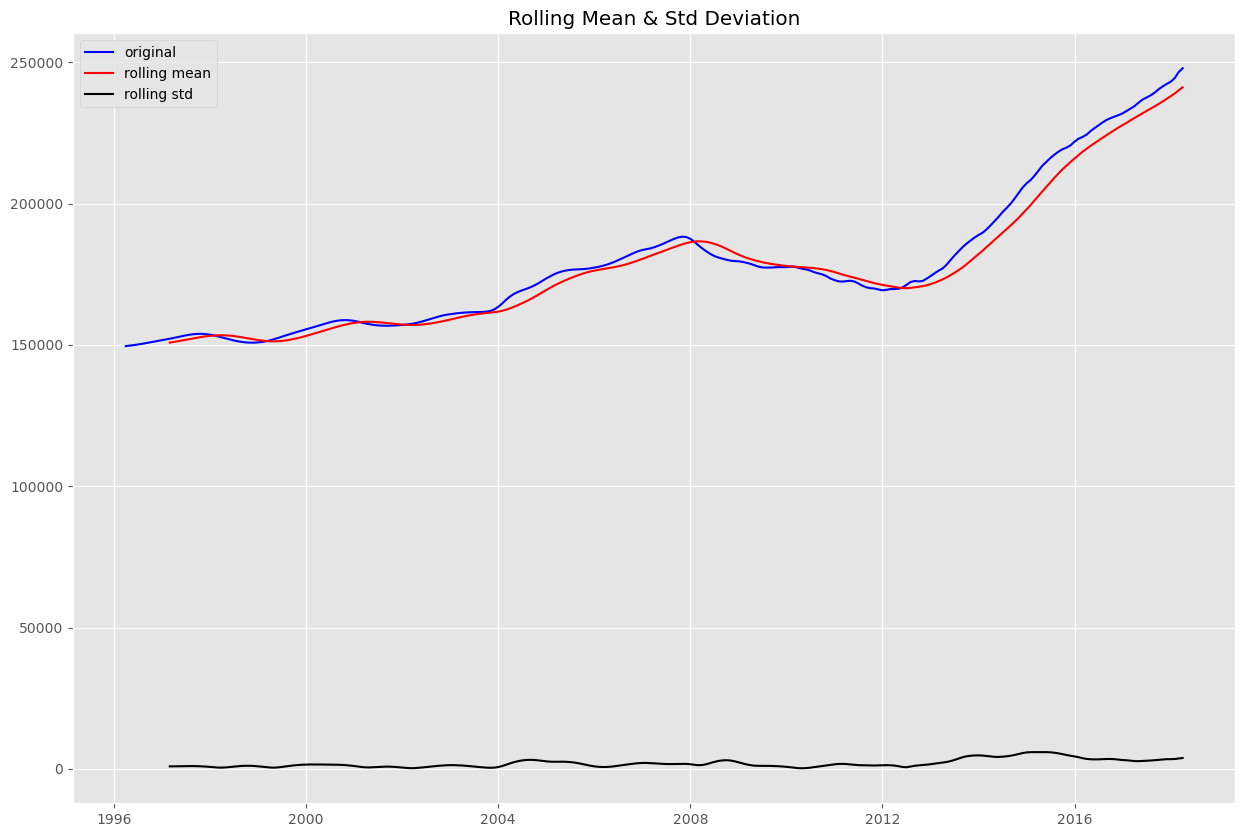

Results of Dickey-Fuller test:
Test Statistic            1.071986
p-value                   0.994970
# Lags used              16.000000
# Observations used     248.000000
Critical Value (1%)      -3.456996
Critical Value (5%)      -2.873266
Critical Value (10%)     -2.573019
dtype: float64


In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Ensure timeseries is a pandas Series
    timeseries = timeseries.squeeze()
    
    # Rolling statistics
    rollmean = timeseries.rolling(window=12).mean()
    rollstd = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(15,10))
    plt.plot(timeseries, color='blue', label='original')
    plt.plot(rollmean, color='red', label='rolling mean')
    plt.plot(rollstd, color='black', label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std Deviation')
    plt.show()
    
    # Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags used', '# Observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Call the function with your timeseries
test_stationarity(Harris_melted)

Interpreting ADF test: Baseline: If the test statistic is more negative than the critical value, you can reject the null hypothesis and conclude that the time series is stationary. If the test statistic is less negative than the critical value, you cannot reject the null hypothesis and conclude that the time series has a unit root (i.e, is non-stationary). If the test statistic is less negative than the critical value, you cannot reject the null hypothesis and conclude that the time series has a unit root. The p-value is the probability of obtaining a test statistic as extreme or more extreme than the observed one under the null hypothesis. If the p-value is less than the significance level, you can reject the null hypothesis and conclude that the time series is stationary. If the p-value is greater than the significance level, you cannot reject the null hypothesis and conclude that the time series has a unit root.

Hence, we cannot reject the null hypothesis and conclude that our time series non stationary.

## 3.2 Decomposing Harris time series

The statsmodels library has a feature called seasonal_decompose. This can break-down a time-series into several components. We will decompose the time series to help us understand the underlying structure of the dataset and separate the systematic patterns (trend and seasonality) from the random fluctuations (residuals). This will aid in:

Pattern Identification: Decomposition helps identify and quantify the trend and seasonality in the data. This helps in understanding the underlying behavior of the phenomenon being observed.

In [16]:
#Selecting historical prices for zipcode_77080
zipcode_77080 = Harris[Harris['RegionName']==77080]

In [17]:
# Melting df zipcode_77080 into time series format
ts77080 = melt_data(zipcode_77080)

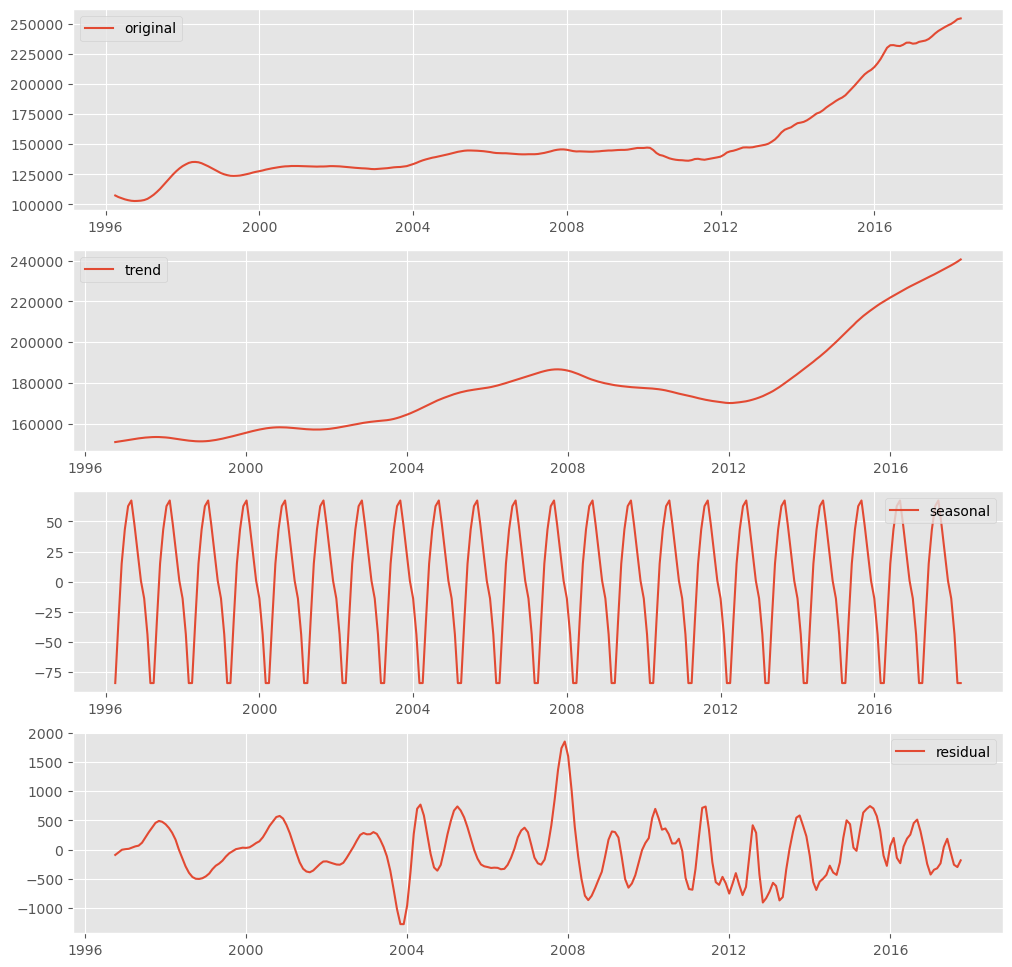

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(Harris_melted)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.figure(figsize=(12,12))
plt.subplot(411)
plt.plot(ts77080, label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='residual')
plt.legend(loc='best')

The decomposition shows us that there is a general upward trend on prices since 1996 and with a steep linear trend as from 2012. We can also see that there is annual seasonality in the housing prices in Harris county, hence the decision to use SARIMA model in our modelling.

## 3.3 Selecting one ZipCode to to build our time series on

We will build a time series model to predict the future ROI for each zip code in Harris county according to the client investment budget preference of USD 200000 and USD 300000. We will build our first Time series model with using zipcode and will later utilize this workflow to extend the Time Series model to all Zipcodes in Harris county to help us come up with the top 5 zipcodes interms of highest CAGR.

We've chose zipcode 77080 given it has highest ROI.

## ZipCode 77080 historical price analysis

In [19]:
ts77080

,value
time,
1996-04-01,107400.0
1996-05-01,106100.0
1996-06-01,105100.0
1996-07-01,104200.0
1996-08-01,103500.0
...,...
2017-12-01,248800.0
2018-01-01,250100.0
2018-02-01,251900.0


## Exploring zipcode 77080 data distribution for normality assumption

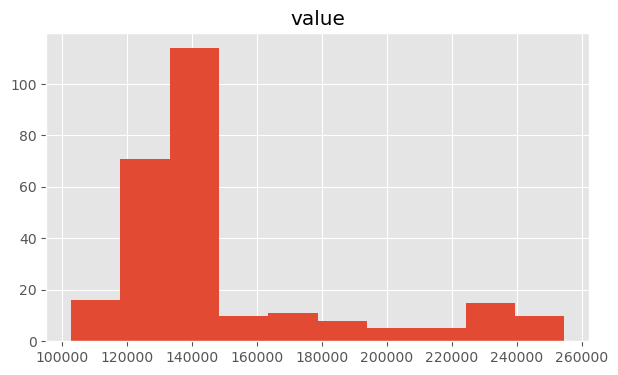

In [20]:
# Plot a histogram
ts77080.hist(figsize = (7,4));

There is a heavy right tail indicating the trend in house prices which have been growing since 1996

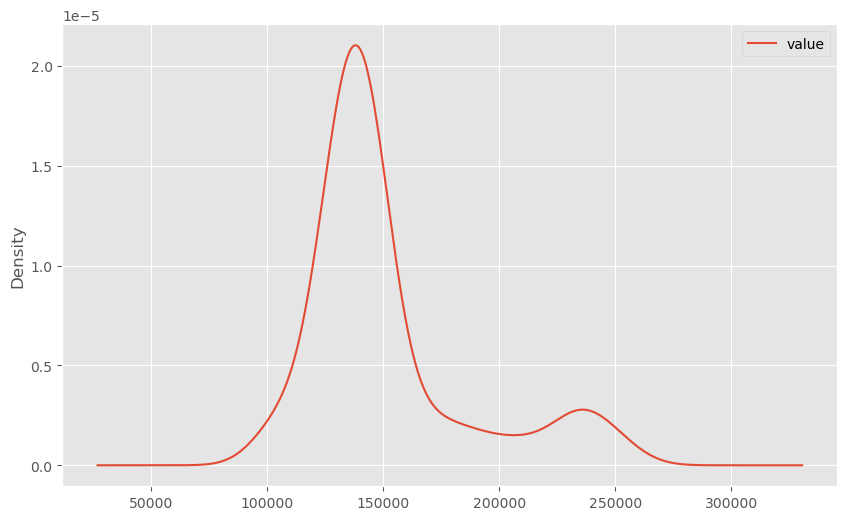

In [21]:
# Plot a density plot 
ts77080.plot(kind='kde', figsize = (10,6));

Shows a long tail

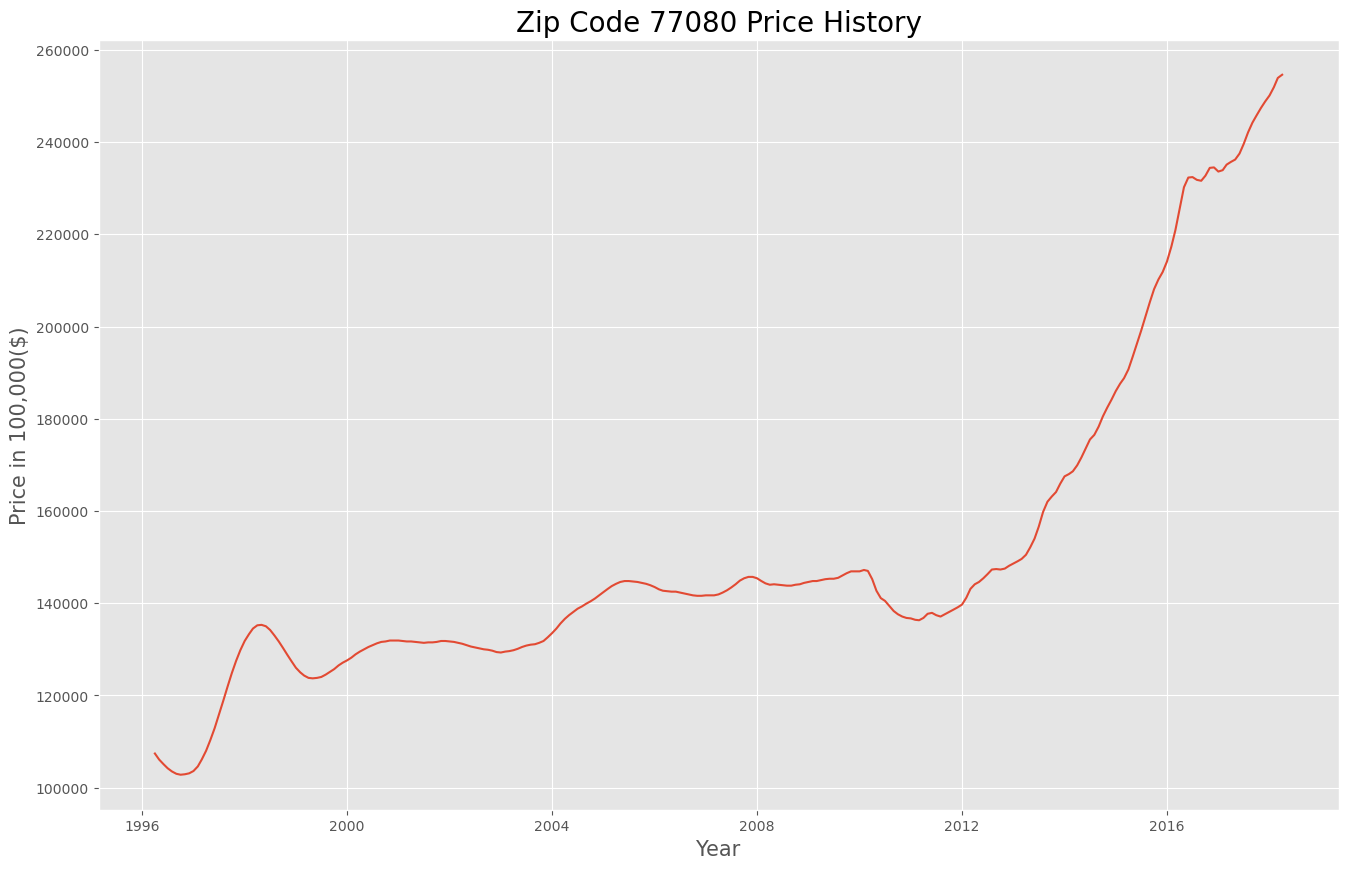

In [22]:
#Visualizing price history for ts77080

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(ts77080)

ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Price in 100,000($)',fontsize=15)
ax.set_title('Zip Code 77080 Price History',fontsize=20);

County 77080's price history creates a trend line similar to that of Harris county as illustrated in the decomposition. The plot shows a positive trend that displays a somewhat linear growth rate in median price as from 2012

## 3.4 Time series modelling for zipcode 77080

## 3.5 Time Series Model Choice - SARIMA

Auto ARIMA is a time series library that automates the process of building a model using ARIMA.
ARIMA - Auto-Regressive Integrated Moving Average (ARIMA) is a time series model that identifies hidden patterns in time series values and makes predictions. ARIMA models assumes that the time series data is stationary (i.e. without trends and seasons). Hence its important to remove the non-stationarity components in the time series before modelling using ARIMA. 
SARIMA models are an extension of ARIMA models that explicitly handle seasonal patterns. Given our dataset has seasonality, we shall use SARIMA for our modelling.
In ARIMA/SARIMA a long manual process is used to establish optimal model parameters (p, d & q). Auto-ARIMA automates the generation of these parameters and recommends the optimal combinations. Its for time reasons that we will use Auto-ARIMA in building our model.
- p (AutoRegressive Order): The number of lag observations included in the model. It represents the number of autoregressive terms
- d (Integration Order): The number of differences needed to make the time series stationary. It represents the degree of differencing applied to the data.
- q (Moving Average Order): The number of lag forecast errors included in the model. It represents the number of moving average terms.

## 3.6 Model training and testing

### 3.6.1 Train - Test Split 

In [23]:
# Splitting data into train and test
train_ts77080 = ts77080[:'2012-04']
test_ts77080 = ts77080['2012-05':]

In [24]:
train_ts77080.isnull().sum()

value    0
dtype: int64

In [25]:
test_ts77080.isna().sum()

value    0
dtype: int64

### 3.6.2 Fitting Auto-ARIMA

As discussed above, Auto-ARIMA finds the p, d & q parameters & identifies the optimal combinations that will return the lowest AIC score. AIC(Akaike Information Criterion) is a measure of how well the model fits the data while penalizing for model complexity, with the lower AIC indicating better fitting model.

In [26]:
from pmdarima.arima import auto_arima
#Grid search for optimal SARIMA parameters
paramsearch= auto_arima(train_ts77080,start_p=2,d=None,start_q=1,max_p=7,max_d=1,max_q=5,start_P=1
                       ,D=1,start_Q=1,max_P=7,max_D=3,max_Q=7,m=12, trace=True,enforce_stationarity=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3117.254, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3115.970, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3125.433, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3117.108, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3117.884, Time=1.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=3118.062, Time=1.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=3115.923, Time=0.54 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=3117.800, Time=1.43 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3116.038, Time=0.27 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=3117.023, Time=0.63 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : 

The parameters ARIMA parameters (2,1,0) and seasonality parameters (0,1,1) output the lowest AIC value.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9217      0.021     43.491      0.000       0.880       0.963
ma.S.L12      -0.3368      0.013    -25.530      0.000      -0.363      -0.311
sigma2      1.358e+05   7691.542     17.654      0.000    1.21e+05    1.51e+05


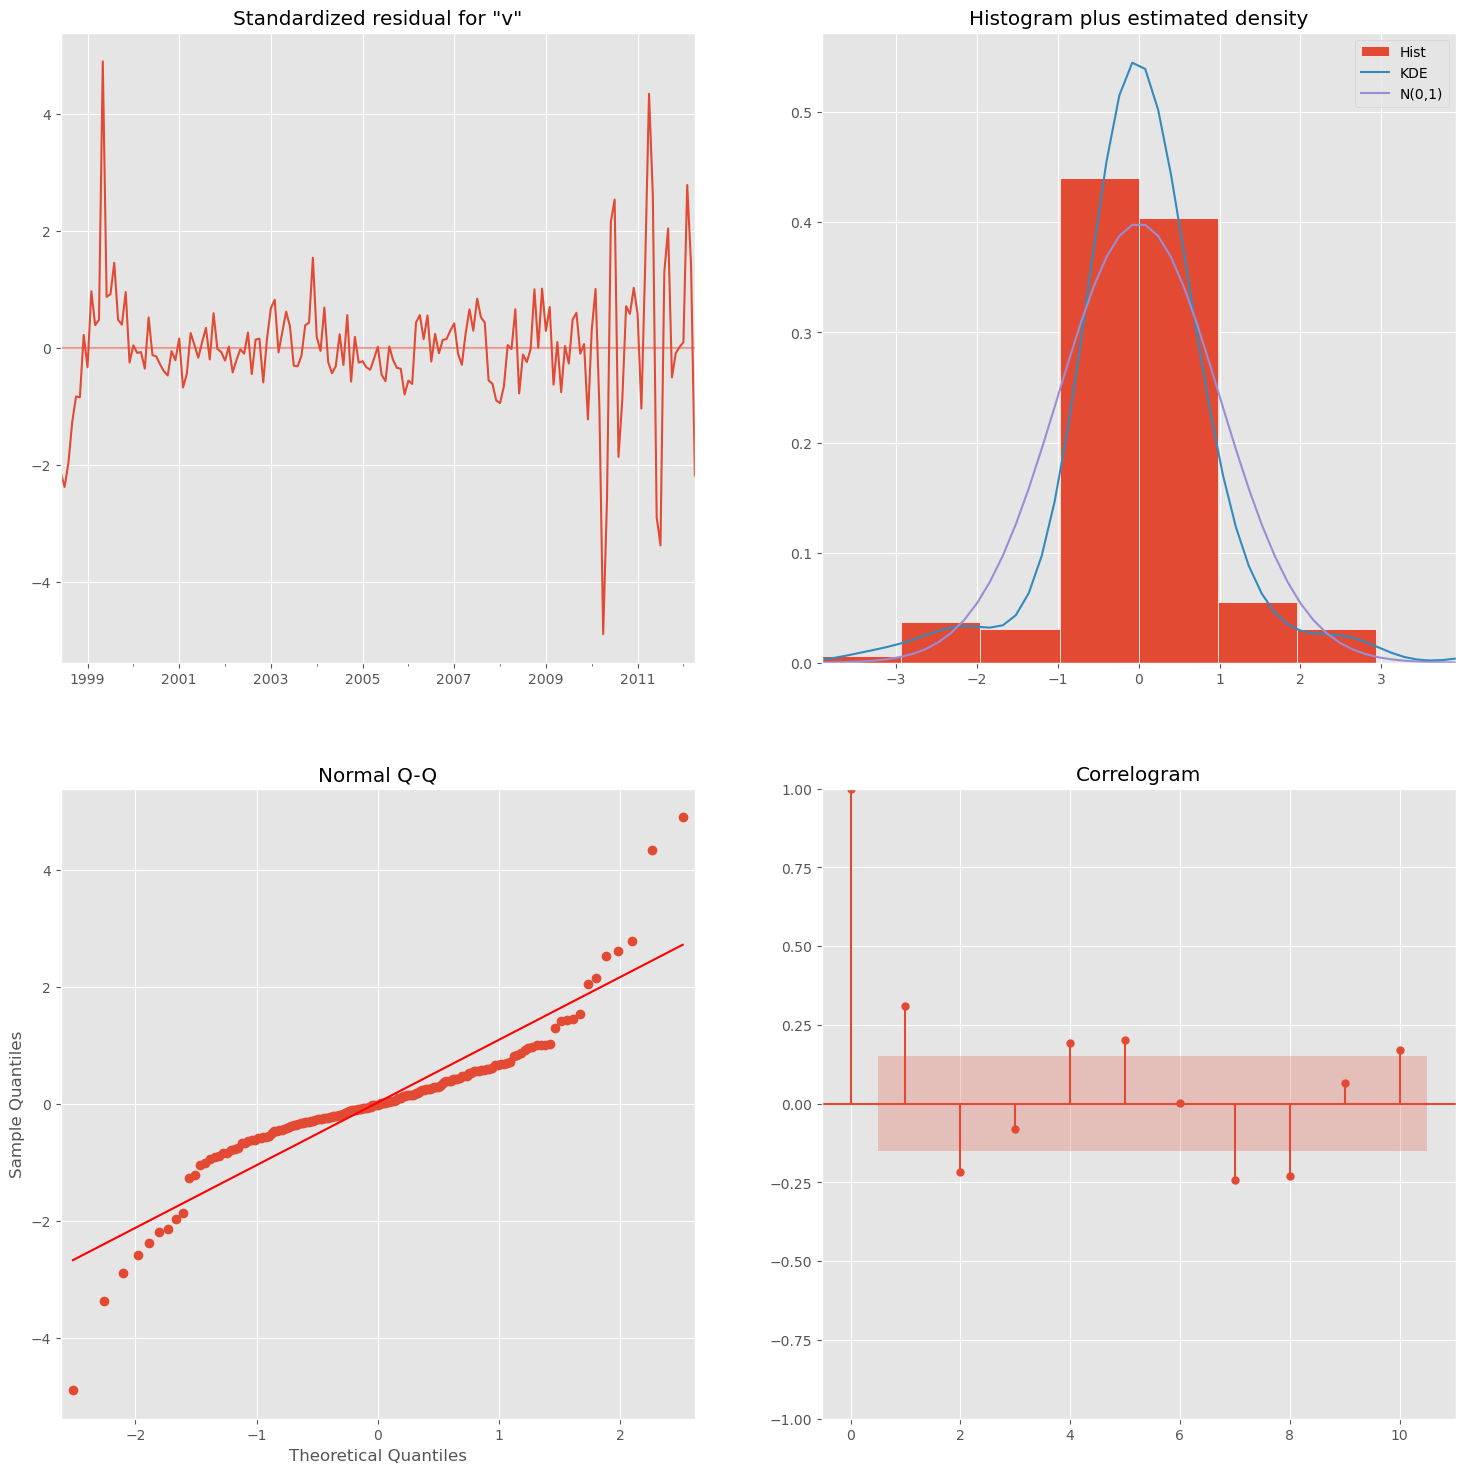

In [27]:
# Plug the optimal parameter values into a new SARIMAX model
model_1 = sm.tsa.statespace.SARIMAX(train_ts77080, 
                                        order=(1,1,0), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = model_1.fit()

print(output.summary().tables[1])
output.plot_diagnostics(figsize=(18,18))
plt.show()

Intepretation:


Histogram & KDE plot - In this plot the KDE line mostly follows along the N(0,1) line which is the standard notation for a normal distribution having a mean of 0 and standard deviation of 1. This shows that the residuals are normally distributed.

QQ-plot - residuals are following the linear trend line. Hence model residuals are normally distributed.

Correlogram - Shows that the time series residuals display low correlations with their lagged versions. This is clearer as we move further along the time series. This tells us there isn't obvious seasonality in our series.

These observations shows that the model does not have correlations and that it satisfactorily fits our data therefore can be relied upon to forecast future prices



### 3.6.3 Reviewing model performance using test data

In [28]:
# Predictions starting from 04-01-2012 and calculate confidence intervals
pred1 = output.get_prediction(start=pd.to_datetime('2012-05'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf1 = pred1.conf_int()
pred_conf1

,lower value,upper value
2012-05-01,144415.354610,145859.826062
2012-06-01,144259.178235,147388.417180
2012-07-01,143650.630920,148731.701410
2012-08-01,142918.466491,150141.950619
2012-09-01,142613.642373,152118.074451
...,...,...
2017-12-01,39389.355802,372721.574751
2018-01-01,36648.397850,377301.783282
2018-02-01,34439.148206,382409.248911
2018-03-01,32466.281634,387738.810767


With predictions for our training data, we can now plot the predictions against our test data.

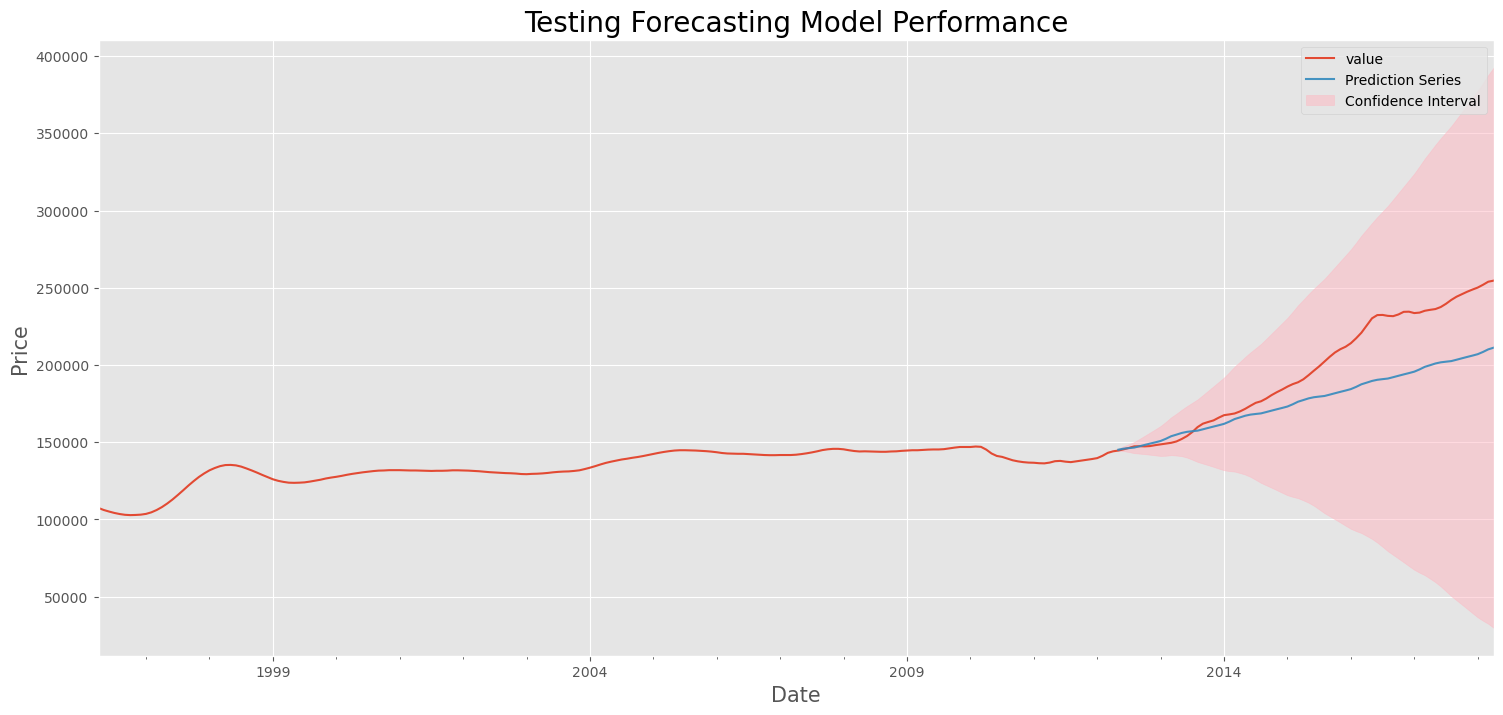

In [36]:
# Plot actual vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot actual values
ax = ts77080.plot(label='Actual Data')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf1.index,
                pred_conf1.iloc[:, 0],
                pred_conf1.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.set_title('Testing Forecasting Model Performance',fontsize=20)
plt.legend()

plt.show()
fig.savefig('Zipcode_77080.png');

Our model was almost perfectly captured the trend between 2012 and 2014. Between 2014 and 2018, our model is conservative resulting in lower forecast values as compated to the actual values.

With our model's forecast not too far off from actual values, we can go ahead and forecast future prices, a duration of 3 years.

In [37]:
# Make predictions on the test set
forecast = output.get_prediction(start=pd.to_datetime('2012-05'), end=pd.to_datetime('2018-04'), dynamic=False)
predicted_values = forecast.predicted_mean

# Extract actual values from the test set
actual_values = test_ts77080

# Align predicted_values and actual_values based on the time index
predicted_values_aligned = predicted_values[actual_values.index]

# Calculate the residuals (prediction errors)
residuals = actual_values['value'] - predicted_values_aligned

# Calculate RMSE
rmse = np.sqrt(np.mean(residuals**2))

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 22273.39


In [38]:
actual_values.head(10)

,value
time,
2012-05-01,144600.0
2012-06-01,145400.0
2012-07-01,146300.0
2012-08-01,147300.0
2012-09-01,147400.0
2012-10-01,147300.0
2012-11-01,147500.0
2012-12-01,148100.0
2013-01-01,148600.0


### 3.6.4 Forecasting the future prices for zipcode 77080

In [39]:
# Plug the parameter values from our Auto ARIMA model into a new SARIMAX model that fits the entire series.
model_2 = sm.tsa.statespace.SARIMAX(ts77080, 
                                        order=(1,1,0), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = model_2.fit()

print(full_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8559      0.024     34.969      0.000       0.808       0.904
ma.S.L12      -0.3228      0.012    -26.831      0.000      -0.346      -0.299
sigma2      3.378e+05   2.03e+04     16.653      0.000    2.98e+05    3.78e+05


In [40]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2018-05-01,254271.542029,256549.886163,255410.714096
2018-06-01,253950.463700,258753.561498,256352.012599
2018-07-01,253686.401033,261292.197073,257489.299053
2018-08-01,253551.666640,264111.735656,258831.701148
2018-09-01,253276.949023,266863.322046,260070.135534
2018-10-01,252977.246709,269610.012332,261293.629521
2018-11-01,252811.117233,272475.713988,262643.415610
2018-12-01,252189.642344,274848.275368,263518.958856
2019-01-01,251398.435723,276997.882442,264198.159082
2019-02-01,251321.185906,279798.254775,265559.720341


Now that we have our 3 year forecast, let's visualize it to see how far we expect the 77080 zipcode to grow by April, 2021.

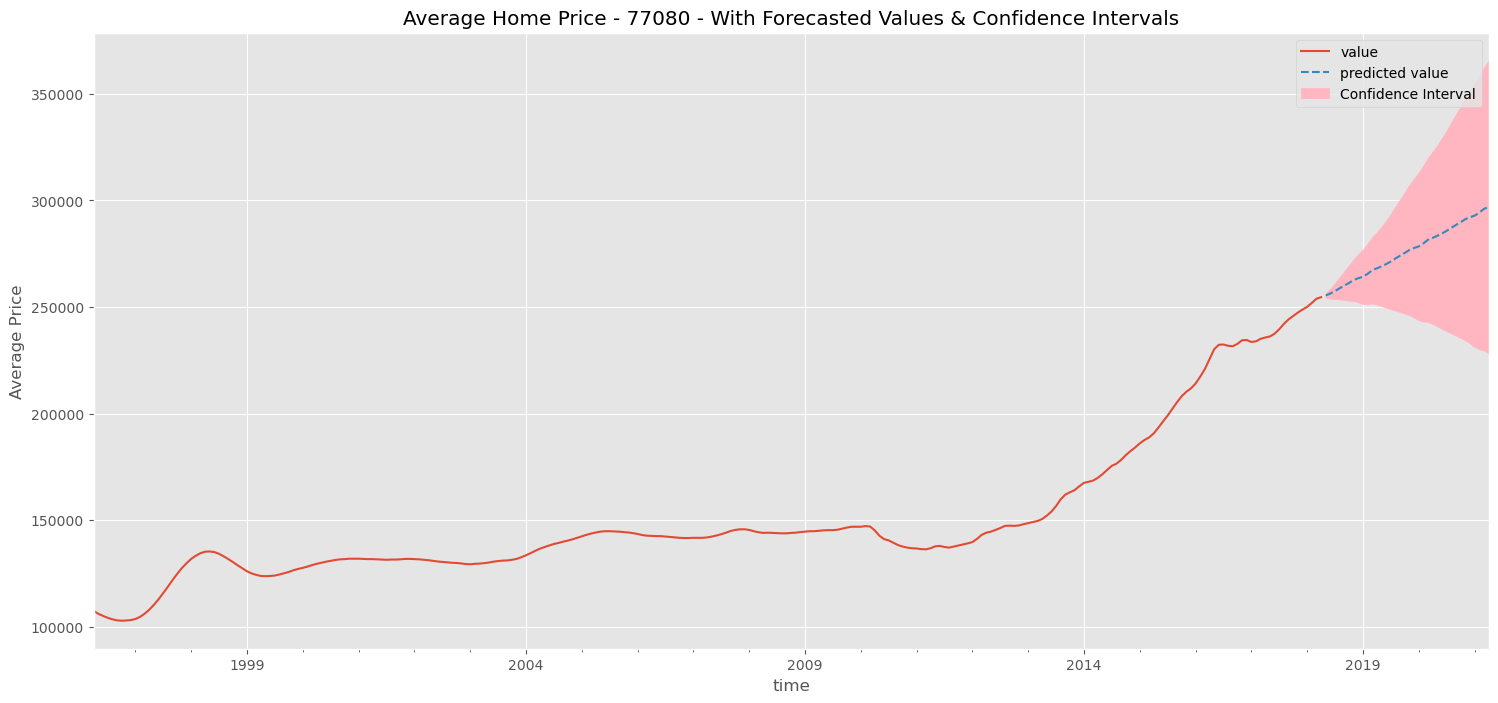

In [41]:
#Plotting the forecast

fig, ax = plt.subplots()
ts77080.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 77080 - With Forecasted Values & Confidence Intervals')
plt.show()
fig.savefig('Zipcode_77080_forecast.png');

Having established a workflow for forecasting future prices for one zipcode, we can now plug in this entire process into a loop to attain our expected prices in April, 2021 for the remaining zipcodes in Harris County

# 3.7 Forecasting on every Zip Code in Harris County 

In [35]:
import pmdarima as pm
#List of Zip Codes in the Harris/Houston metro region within client's budget.
#Harris_budget_zips = [a for a in Harris_budget['RegionName']]

zip_predictions = {}

for zipcode in Harris_budget_zips:
    
    #Melting the time series of our given zipcode
    series = melt_data(df[df['RegionName']== zipcode])
    
    
    # Splitting df inot train and test dataset.
    train_series = series[:'2012-04']
    test_series = series['2012-05':]
    
    
    #Parameter search using Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=7, max_q=5, max_d=1,
                     m=12,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=1, max_P=7,
                     max_D=3,max_Q=7,
                     trace=True,
                     enforce_stationarity=False,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
   
    print("Auto ARIMA Model Summary:")
    print(auto_model.summary())
    
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    print("SARIMAX Model Summary:")
    print(output.summary())

    # Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1])
                                - (series['value'][-1]))/ (series['value'][-1])

print("Zip Code Predictions:")
for zipcode, prediction in zip_predictions.items():
    print(f"Zip Code {zipcode}: ROI Prediction = {prediction}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3746.010, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=3675.529, Time=0.99 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=3696.911, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3688.119, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=3675.231, Time=2.47 sec
 ARIMA(1,0,0)(3,1,0)[12]             : AIC=3691.242, Time=4.70 sec
 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=2.95 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(1,0,0)(3,1,1)[12]             : AIC=5413.354, Time=4.37 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=3745.460, Time=0.38 sec
 ARIMA(2,0,0)(2,1,0)[12]             : AIC=3785.058, Time=2.37 sec
 ARIMA(1,0,1)(2,1,0)[12]             : AIC=3677.262, Time=2.80 sec
 ARIMA(0,0,1)(2,1,0)[12]             : AIC=3696.516, Time=0.63 sec
 ARIMA(2,0,1)(2,1,0)[12]             : AIC=inf, Time=3.29 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept

SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1949.861
Date:                            Sun, 17 Sep 2023   AIC                           3907.721
Time:                                    20:43:07   BIC                           3921.439
Sample:                                04-01-1996   HQIC                          3913.256
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9936      0.006    178.089      0.000       0.983       1.005
ar.S.L12    

 ARIMA(2,0,1)(1,1,0)[12]             : AIC=6676.889, Time=1.58 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(1,0,0)(1,1,0)[12]          
Total fit time: 11.534 seconds
Auto ARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  193
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -1778.207
Date:                            Sun, 17 Sep 2023   AIC                           3562.414
Time:                                    20:44:03   BIC                           3572.009
Sample:                                04-01-1996   HQIC                          3566.304
                                     - 04-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err       

 ARIMA(1,0,0)(1,1,0)[12]             : AIC=3626.573, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=3632.772, Time=0.62 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3626.464, Time=0.27 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(2,0,0)(0,1,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=3631.058, Time=0.12 sec
 ARIMA(2,0,1)(0,1,0)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3625.306, Time=0.33 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=4.10 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=3624.336, Time=1.91 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : A

SARIMAX Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  265
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood               -2389.757
Date:                             Sun, 17 Sep 2023   AIC                           4785.513
Time:                                     20:45:12   BIC                           4795.968
Sample:                                 04-01-1996   HQIC                          4789.725
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9834      0.079     12.480      0.000       0.829       1.138
ar.S

 ARIMA(1,0,0)(1,1,0)[12]             : AIC=3641.325, Time=1.03 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=3683.464, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3641.189, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(2,0,0)(0,1,0)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=3643.188, Time=0.43 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=3692.552, Time=0.08 sec
 ARIMA(2,0,1)(0,1,0)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3640.782, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3641.309, Time=1.28 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=3641.014, Time=1.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3750.319, Time=0.03 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=3642.655, Time=0.39 sec
 ARIMA(1,0,1)(0,1,0)

SARIMAX Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  265
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood               -1832.110
Date:                             Sun, 17 Sep 2023   AIC                           3676.221
Time:                                     20:52:17   BIC                           3696.797
Sample:                                 04-01-1996   HQIC                          3684.523
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0062      0.008    121.362      0.000       0.990       1.022
ma.L

 ARIMA(1,0,0)(1,1,0)[12]             : AIC=3545.080, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=3598.375, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3555.052, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=3473.767, Time=2.18 sec
 ARIMA(1,0,0)(3,1,0)[12]             : AIC=inf, Time=2.51 sec
 ARIMA(1,0,0)(2,1,1)[12]             : AIC=3455.418, Time=2.62 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=5.44 sec
 ARIMA(1,0,0)(3,1,1)[12]             : AIC=inf, Time=4.76 sec
 ARIMA(1,0,0)(2,1,2)[12]             : AIC=3450.698, Time=2.98 sec
 ARIMA(1,0,0)(1,1,2)[12]             : AIC=3484.519, Time=2.38 sec
 ARIMA(1,0,0)(3,1,2)[12]             : AIC=3811.680, Time=5.27 sec
 ARIMA(1,0,0)(2,1,3)[12]             : AIC=3797.929, Time=4.53 sec
 ARIMA(1,0,0)(1,1,3)[12]             : AIC=3567.483, Time=4.73 sec
 ARIMA(1,0,0)(3,1,3)[12]             : AIC=3770.334, Time=6.11 sec
 ARIMA(0,0,0)(2,1,2)[12]             : AIC=3526.672, Time=1.60 sec
 ARIMA(2,0

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3686.854, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=3598.198, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=3629.942, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3599.670, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=inf, Time=6.07 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=3.01 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=3685.132, Time=0.13 sec
 ARIMA(2,0,0)(1,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(1,1,0)[12]             : AIC=3801.713, Time=1.36 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=3629.942, Time=0.17 sec
 ARIMA(2,0,1)(1,1,0)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3596.743, Time=0.96 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3595.44

SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(3, 1, 0, 12)   Log Likelihood               -1817.438
Date:                            Sun, 17 Sep 2023   AIC                           3644.877
Time:                                    20:56:16   BIC                           3661.753
Sample:                                04-01-1996   HQIC                          3651.695
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0067      0.006    167.501      0.000       0.995       1.019
ar.S.L12    

 ARIMA(0,0,2)(2,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(1,0,2)(1,1,0)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,0,3)(1,1,0)[12]             : AIC=3605.841, Time=0.31 sec
 ARIMA(0,0,3)(0,1,0)[12]             : AIC=3608.421, Time=0.13 sec
 ARIMA(0,0,3)(2,1,0)[12]             : AIC=3607.655, Time=1.00 sec
 ARIMA(0,0,3)(1,1,1)[12]             : AIC=3607.761, Time=1.21 sec
 ARIMA(0,0,3)(0,1,1)[12]             : AIC=3605.945, Time=0.31 sec
 ARIMA(0,0,3)(2,1,1)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(1,0,3)(1,1,0)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,0,4)(1,1,0)[12]             : AIC=3606.939, Time=0.38 sec
 ARIMA(1,0,4)(1,1,0)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,0,3)(1,1,0)[12] intercept   : AIC=3583.418, Time=0.35 sec
 ARIMA(0,0,3)(0,1,0)[12] intercept   : AIC=3591.099, Time=0.17 sec
 ARIMA(0,0,3)(2,1,0)[12] intercept   : AIC=3584.941, Time=1.05 sec
 ARIMA(0,0,3)(1,1,1)[12] intercept   : AIC=3582.629, Time=1.05 sec
 ARIMA(0,0,3)(0,1,1)

SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(4, 1, 0, 12)   Log Likelihood               -1711.359
Date:                            Sun, 17 Sep 2023   AIC                           3434.718
Time:                                    20:59:39   BIC                           3454.627
Sample:                                04-01-1996   HQIC                          3442.772
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0078      0.006    169.617      0.000       0.996       1.019
ar.S.L12    

 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3713.431, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=3774.270, Time=0.11 sec
 ARIMA(2,0,0)(1,1,0)[12]             : AIC=3710.921, Time=0.88 sec
 ARIMA(1,0,1)(1,1,0)[12]             : AIC=3730.866, Time=1.30 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=3727.504, Time=0.17 sec
 ARIMA(2,0,1)(1,1,0)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=5.53 sec

Best model:  ARIMA(1,0,0)(1,1,0)[12]          
Total fit time: 20.278 seconds
Auto ARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  193
Model: 

 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3866.473, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[12]             : AIC=3780.852, Time=0.17 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=3778.956, Time=0.09 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=3780.838, Time=0.14 sec
 ARIMA(0,0,1)(1,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AIC=3683.134, Time=0.37 sec
 ARIMA(1,0,1)(1,1,0)[12]             : AIC=3717.843, Time=1.65 sec
 ARIMA(1,0,1)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,0,1)(1,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=3682.233, Time=0.16 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(2,0,0)(0,1,0)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(0,1,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept  

SARIMAX Model Summary:
                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(4, 1, [1], 12)   Log Likelihood               -1791.817
Date:                              Sun, 17 Sep 2023   AIC                           3597.634
Time:                                      21:04:11   BIC                           3620.861
Sample:                                  04-01-1996   HQIC                          3607.030
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0069      0.007    150.798      0.000       0.994       1.

# 3.8 Recommendations & conclusions

Using the forecasts calculated above, we'll now identify the Top 5 Zipcodes

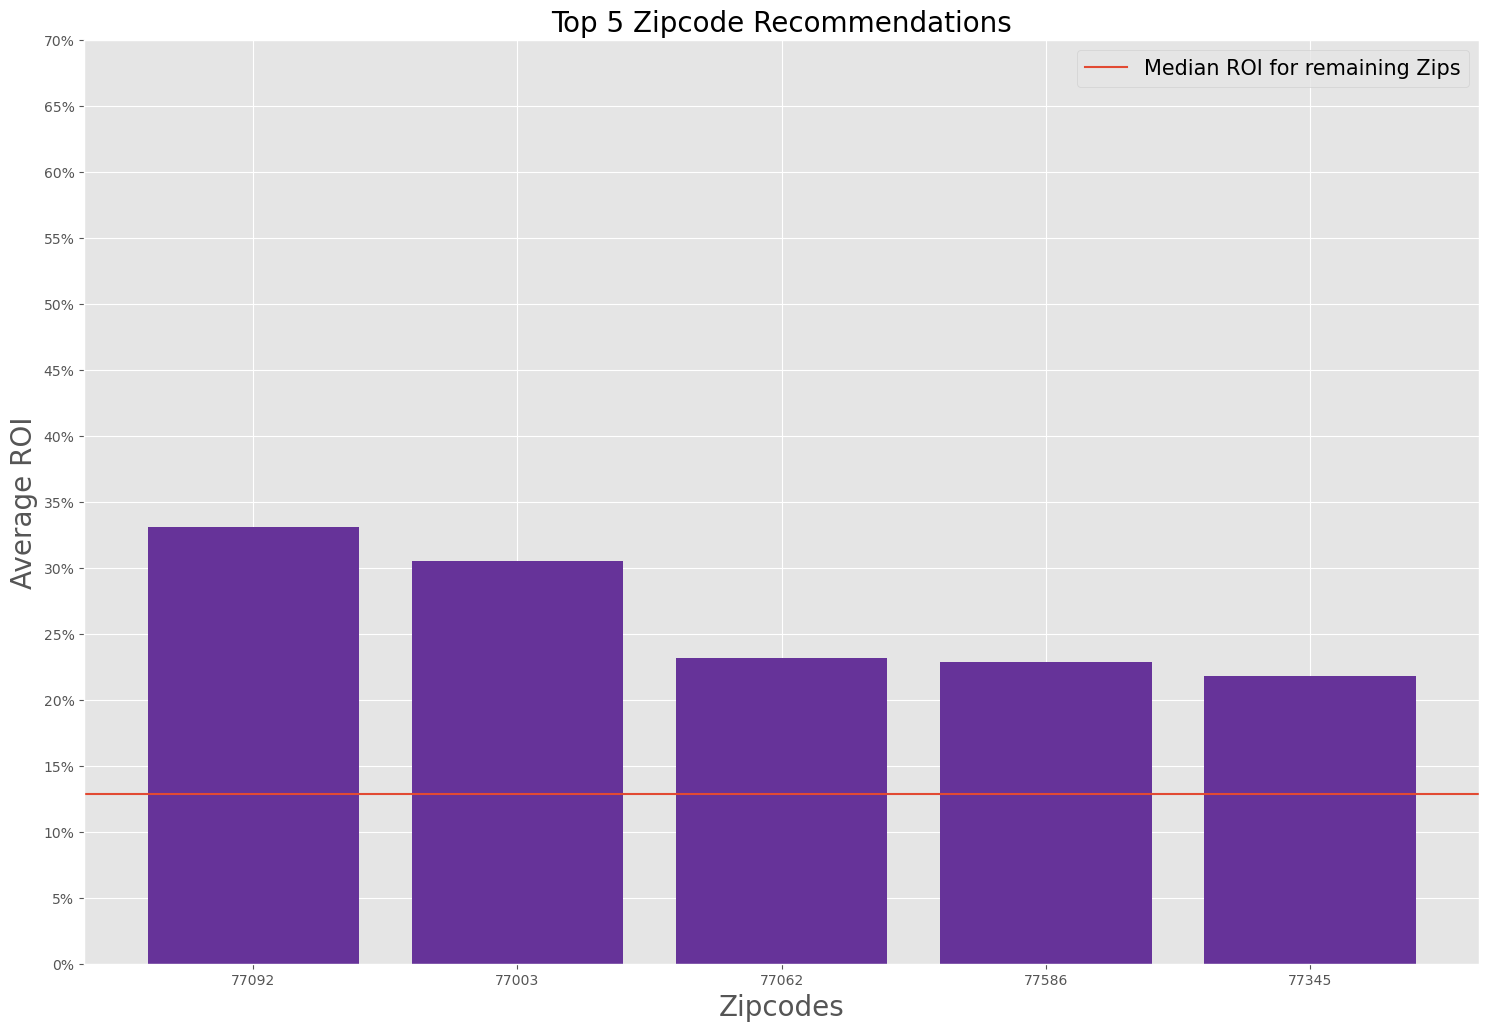

In [42]:
# Sorting the 3 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
    sorted_forecast_3yr[i[0]] = i[1]

#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

fig, ax = plt.subplots(figsize=(18,12))

x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],
            top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],
     top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='rebeccapurple')
remaining_zipcodes = list(sorted_forecast_3yr.items())[5:]
median_ROI_other_zips = remaining_zipcodes[5][1]
ax.axhline(y=median_ROI_other_zips,label = 'Median ROI for remaining Zips')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([(a/100) for a in list(range(0,75,5))])
ax.set_yticklabels([str(a)+'%' for a in list(range(0,75,5))])
ax.set_title('Top 5 Zipcode Recommendations', fontsize=20)
ax.set_ylabel('Average ROI', fontsize=20)
ax.set_xlabel('Zipcodes',fontsize=20)
ax.legend(prop={'size': 15})
fig.savefig('Top5_zipcodes.png');

Our model forecasted house prices for the future period between 2018 & 2021. Above, we see the predicted top 5 zip codes interms of highest ROI; i.e., 77092, 77003, 77062, 77586 and 77345 whose ROI in the next 3 years will be between 23% & 33%

### Conclusion

We recommend that our client invests in the top five zip codes listed below:

In [43]:
print("Zip Code Predictions:")
# Sort zip_predictions by values in descending order and get the top five items
top_five_predictions = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)[:5]

for zipcode, prediction in top_five_predictions:
    # Format the prediction as a percentage with two decimal points
    prediction_percentage = round(prediction * 100, 2)
    print(f"Zip Code {zipcode}: {prediction_percentage}%")

Zip Code Predictions:
Zip Code 77092: 33.09%
Zip Code 77003: 30.54%
Zip Code 77062: 23.13%
Zip Code 77586: 22.86%
Zip Code 77345: 21.81%
